<a href="https://colab.research.google.com/github/gimhee/CV/blob/main/AlexNet_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Modules**

In [1]:
# Utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid

# sklearn
from sklearn.metrics import confusion_matrix, classification_report

**Hyperparameters**

In [2]:
learning_rate = 0.0001
training_epochs = 10
batch_size = 128

**CIFAR-10 dataset**

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:12<00:00, 13892443.54it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

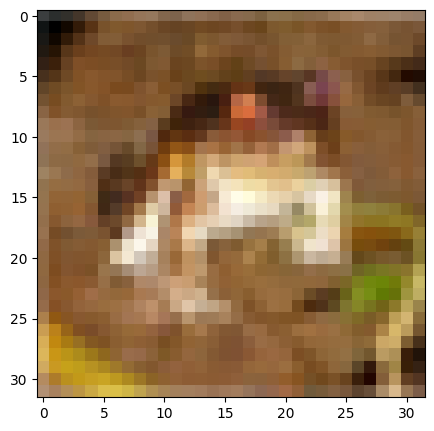

In [5]:
#check the data(image)
dataiter = iter(train_set)
images, labels = next(dataiter)

img   = make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(5, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

**Image Preprocessing**
- normalize by RGB channel (mean, STD)
- resize and crop the image

In [6]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_set]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_set]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(train_stdR, train_stdG, train_stdB)

0.49139965 0.48215845 0.4465309
0.20220213 0.19931543 0.20086348


In [7]:
train_transformer = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.CenterCrop(227),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[train_meanR, train_meanG, train_meanB],
                                                             std=[train_stdR, train_stdG, train_stdB])])

train_set.transform = train_transformer
test_set.transform = train_transformer

**AlexNet Model**

Instead of ImageNet, using CIFAR-10. Thus, the number of paramater is slightly different(62,378,344 -> 58,322,314)

(the last FC layer output is 10, instead of 1000 because of the number of classes)

In [8]:
class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()

        #five convolution layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        #three fully-connected layers
        self.fc = nn.Sequential(
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=10),
            nn.LogSoftmax(dim=1)
        )

        self.apply(self._init_weight_bias)

    def _init_weight_bias(self, module):    #가중치
        classname = module.__class__.__name__
        if classname == 'Conv2d':
            nn.init.normal_(module.weight, mean=0.0, std=0.01)
            nn.init.constant_(module.bias, 0)
            if (module.in_channels == 96 or module.in_channels == 384):
              nn.init.constant_(module.bias, 1)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)   #fully-connected layer에 넣기 위해 Flatten
        x = self.fc(x)

        return x

**Set Device and Model (w. loss, optimizer)**

In [9]:
use_cuda = torch.cuda.is_available()
print("use_cuda : ", use_cuda)

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda:0" if use_cuda else "cpu")

net = AlexNet().to(device)

X = torch.randn(size=(1,3,227,227)).type(FloatTensor)
print(net(X))
print(summary(net, (3,227,227)))

use_cuda :  True
tensor([[-2.6906, -2.1422, -2.5089, -2.0479, -2.5362, -2.0646, -2.3612, -2.1455,
         -2.4216, -2.3200]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,

In [10]:
model = AlexNet().to(device)
criterion = F.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Training**

In [22]:
def train(model, train_loader, epoch):
    model.train()
    for batch_idx, (data,target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print(f"{batch_idx*len(data)}/{len(train_loader.dataset)}")

In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='mean').item()
            pred = output.argmax(1)
            correct += float((pred == target).sum())

        test_loss /= len(test_loader.dataset)
        correct /= len(test_loader.dataset)

        return test_loss, correct

In [25]:
for epoch in tqdm(range(1, training_epochs + 1)):
    train(model, trainloader, epoch)
    test_loss, test_accuracy = test(model, device, testloader)

    print('\n Epoch : {:>3}   Loss : {:>.9}   Accuracy : {:>.9}' .format(epoch, test_loss, test_accuracy))

  0%|          | 0/10 [00:00<?, ?it/s]

0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 10%|█         | 1/10 [02:06<18:56, 126.30s/it]


 Epoch :   1   Loss : 0.00823301883   Accuracy : 0.6308
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 20%|██        | 2/10 [04:26<17:54, 134.28s/it]


 Epoch :   2   Loss : 0.00740933921   Accuracy : 0.6782
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 30%|███       | 3/10 [06:31<15:11, 130.27s/it]


 Epoch :   3   Loss : 0.00706236147   Accuracy : 0.7009
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 40%|████      | 4/10 [08:36<12:48, 128.08s/it]


 Epoch :   4   Loss : 0.00702854063   Accuracy : 0.7076
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 50%|█████     | 5/10 [10:38<10:30, 126.02s/it]


 Epoch :   5   Loss : 0.00715350426   Accuracy : 0.7183
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 60%|██████    | 6/10 [12:44<08:23, 125.79s/it]


 Epoch :   6   Loss : 0.00800642365   Accuracy : 0.7183
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 70%|███████   | 7/10 [14:48<06:15, 125.20s/it]


 Epoch :   7   Loss : 0.00854281142   Accuracy : 0.7212
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 80%|████████  | 8/10 [16:51<04:09, 124.62s/it]


 Epoch :   8   Loss : 0.00892837604   Accuracy : 0.721
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


 90%|█████████ | 9/10 [18:55<02:04, 124.41s/it]


 Epoch :   9   Loss : 0.0100845696   Accuracy : 0.7118
0/50000
6400/50000
12800/50000
19200/50000
25600/50000
32000/50000
38400/50000
44800/50000


100%|██████████| 10/10 [20:59<00:00, 125.95s/it]


 Epoch :  10   Loss : 0.00985071216   Accuracy : 0.7286


**Evaluation**

In [27]:
classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

In [34]:
y_pred = []
y_true = []

for x, y in torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size):

    x = x.to(device)
    y = y.to(device)
    z = model(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

Text(0.5, 1.0, 'Confusion Matrix of AlexNet (CIFAR10)')

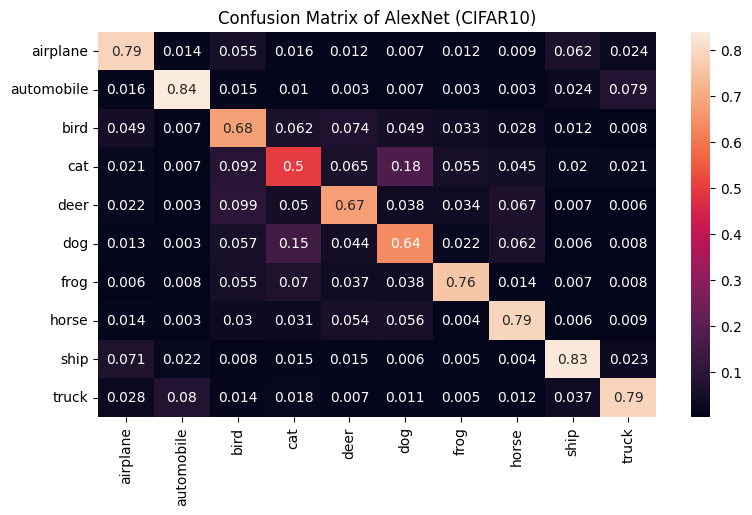

In [35]:
#Confusion matrix(Hit map)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (9,5))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix of AlexNet (CIFAR10)')

In [52]:
#Classification Report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1000
           1       0.85      0.84      0.85      1000
           2       0.61      0.68      0.64      1000
           3       0.54      0.50      0.52      1000
           4       0.68      0.67      0.68      1000
           5       0.62      0.64      0.63      1000
           6       0.81      0.76      0.78      1000
           7       0.76      0.79      0.78      1000
           8       0.82      0.83      0.83      1000
           9       0.81      0.79      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

